# Lecture 17 - PU Learning

```{contents}
:local:
:depth: 1
```

## Learning goals
- Define **semi-supervised learning**, the LU setting (labeled + unlabeled), and the PU setting (positive + unlabeled).
- Understand assumptions used by common PU methods
- Build a simple PU workflow on a chemistry example
- Practice evaluation ideas when true negatives are missing.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1fgX-_4YDnCRNl7QZsw_Cy2ZMtzv55txH?usp=sharing)  

## 1. Setup

In [1]:
# Imports kept minimal and friendly for beginners
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
np.random.seed(17)
plt.rcParams['figure.figsize'] = (5.2, 3.4)
plt.rcParams['axes.grid'] = True

## 2. Semi-supervised learning overview

Semi-supervised learning uses both labeled and unlabeled data. In chemistry, unlabeled examples come from historical experiments without reliable outcomes or from conditions that were not measured for the desired property.

Two common settings:

- **LU**: You have labeled points with $y\in\{0,1\}$ and an unlabeled pool with unknown $y$.
- **PU**: You only have some positives labeled ($s=1$ indicates selected/labeled) and a large unlabeled pool that mixes positives and negatives. No confirmed negatives.

We will connect LU to PU to build intuition. LU is often easier to evaluate because you do have negatives labeled. PU is closer to many lab scenarios where successes are reported, while failures and non-attempts blend in the unlabeled pool.

We will first try tiny LU toy model. Imagine a feature $x$ that combines a reaction temperature-like number and a simple composition flag. We learn $y=1$ for successful outcomes and $y=0$ for failures. This is LU, not PU. The goal is only to build intuition for semi-supervised ideas.

In [2]:
# Build a tiny LU toy dataset (harder, still simple)
import numpy as np

rng = np.random.default_rng(0)

# Keep sizes the same
n_pos, n_neg, n_unlab = 40, 30, 500

# Make classes closer and a bit wider to create overlap
x_pos = np.column_stack([
    rng.normal(0.68, 0.14, n_pos),   # mean moved down, variance up
    rng.integers(0, 2, n_pos)        # binary flag
])

x_neg = np.column_stack([
    rng.normal(0.45, 0.16, n_neg),   # mean moved up, variance up
    rng.integers(0, 2, n_neg)
])

X_lab = np.vstack([x_pos, x_neg])
y_lab = np.hstack([np.ones(n_pos, dtype=int), np.zeros(n_neg, dtype=int)])

# Unlabeled pool centered between the two with some spread
X_unlab = np.column_stack([
    rng.normal(0.56, 0.20, n_unlab),
    rng.integers(0, 2, n_unlab)
])

# Small label noise to avoid perfect separability
flip_mask = rng.random(y_lab.size) < 0.15  # 15% flips
y_lab_noisy = y_lab.copy()
y_lab_noisy[flip_mask] = 1 - y_lab_noisy[flip_mask]

print(X_lab.shape, y_lab_noisy.shape, X_unlab.shape)
X_lab[:3]


(70, 2) (70,) (500, 2)


array([[0.69760223, 1.        ],
       [0.66150532, 1.        ],
       [0.76965917, 0.        ]])

Now we can inspect the distributions:

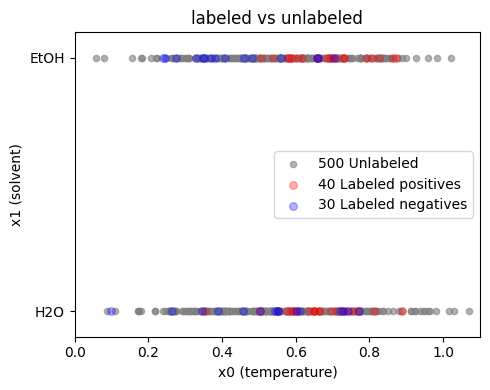

In [3]:
pos = (y_lab == 1)
neg = (y_lab == 0)

plt.figure(figsize=(5, 4))

plt.scatter(X_unlab[:, 0], X_unlab[:, 1], color='grey', label='500 Unlabeled', alpha=0.6, s=20)
plt.scatter(X_lab[pos, 0], X_lab[pos, 1], color='red', label='40 Labeled positives', alpha=0.3, s=30)
plt.scatter(X_lab[neg, 0], X_lab[neg, 1], color='blue', label='30 Labeled negatives', alpha=0.3, s=30)


plt.xlabel('x0 (temperature)')
plt.ylabel('x1 (solvent)')
plt.title('labeled vs unlabeled')

plt.xlim(0.0, 1.0)
plt.ylim(-0.2, 1.2)
plt.xlim(0.0, 1.1)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ['H2O', 'EtOH'])
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

**LU learning** assumes we have labeled positives and labeled negatives. We can train a standard classifier and use unlabeled data in helpful ways such as self-training or consistency regularization. Here we only sketch a minimal baseline: supervised learning on the labeled set, then scoring the unlabeled.

In [4]:
# Use y_lab_noisy from your tiny dataset cell
Xtr, Xte, ytr, yte = train_test_split(
    X_lab, y_lab_noisy, test_size=0.25, random_state=1, stratify=y_lab_noisy
)

sc = StandardScaler().fit(Xtr)
Xtr_s = sc.transform(Xtr)
Xte_s = sc.transform(Xte)

base = LogisticRegression(max_iter=200, random_state=1)
base.fit(Xtr_s, ytr)
auc_base = roc_auc_score(yte, base.predict_proba(Xte_s)[:, 1])
print("Supervised baseline ROC AUC:", round(auc_base, 3))


Supervised baseline ROC AUC: 0.688


The LU baseline above shows ordinary supervised behavior. The unlabeled pool below is not needed to train, but later can be scored for prioritization.

In [5]:
# Semi-supervised: one simple self-training pass using the unlabeled pool
X_unlab_s = sc.transform(X_unlab)
p_unlab = base.predict_proba(X_unlab_s)[:, 1]

# Pick very confident pseudo-labels
hi_pos = (p_unlab >= 0.70)
hi_neg = (p_unlab <= 0.30)

# Build an enlarged training set with pseudo-labels
X_st = np.vstack([Xtr_s, X_unlab_s[hi_pos], X_unlab_s[hi_neg]])
y_st = np.hstack([
    ytr,
    np.ones(hi_pos.sum(), dtype=int),
    np.zeros(hi_neg.sum(), dtype=int),
])

print(f"Added {hi_pos.sum()} pseudo-positives and {hi_neg.sum()} pseudo-negatives")

# Retrain on labeled + pseudo-labeled
st = LogisticRegression(max_iter=200, random_state=5)
st.fit(X_st, y_st)

auc_st = roc_auc_score(yte, st.predict_proba(Xte_s)[:, 1])
print("Self-training ROC AUC:", round(auc_st, 3))


Added 167 pseudo-positives and 66 pseudo-negatives
Self-training ROC AUC: 0.714


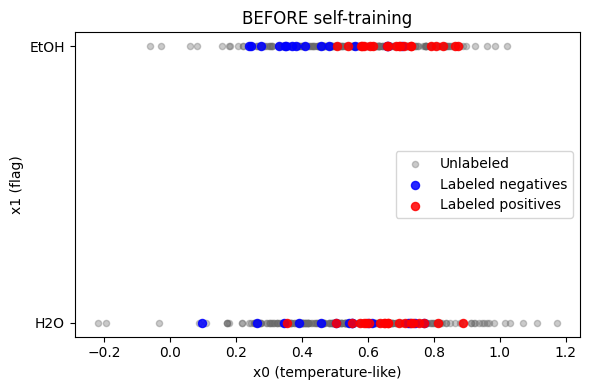

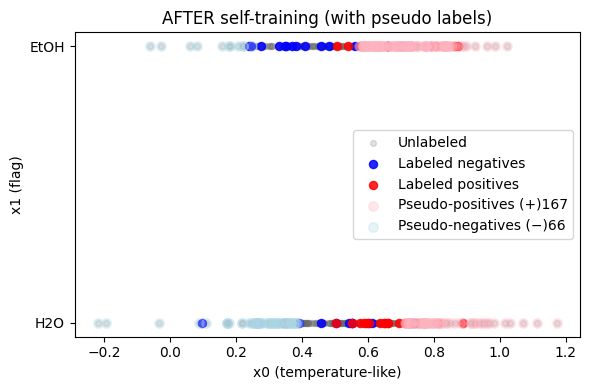

In [6]:
# Normal 2D plotting (no t-SNE): show labeled vs unlabeled, then highlight pseudo labels
# Assumes the following are defined from your workflow:
# X_lab, y_lab, X_unlab         -> original features (not standardized) with shape (*, 2) for plotting
# sc, base, Xtr_s, ytr, Xte_s, yte -> scaler/model and splits already fit
# hi_pos, hi_neg                -> boolean masks over X_unlab selecting pseudo-positives/negatives
# st                            -> the retrained model (optional, only for the print above)

import numpy as np
import matplotlib.pyplot as plt

# Convenience masks
pos = (y_lab == 1)
neg = (y_lab == 0)

# --- Figure 1: BEFORE self-training (plain scatter) ---
plt.figure(figsize=(6, 4))
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], color='dimgray', alpha=0.35, s=20, label='Unlabeled')
plt.scatter(X_lab[neg, 0], X_lab[neg, 1], color='blue', alpha=0.85, s=34, label='Labeled negatives')
plt.scatter(X_lab[pos, 0], X_lab[pos, 1], color='red',  alpha=0.85, s=34, label='Labeled positives')
plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (flag)')
plt.title('BEFORE self-training')
plt.yticks([0, 1], ['H2O', 'EtOH'])
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

# --- Figure 2: AFTER self-training (highlight pseudo labels with orange/purple) ---
# hi_pos / hi_neg are boolean masks over the *unlabeled* pool
idx_hi_pos = np.where(hi_pos)[0]
idx_hi_neg = np.where(hi_neg)[0]

plt.figure(figsize=(6, 4))
# base layer
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], color='dimgray', alpha=0.20, s=18, label='Unlabeled')
plt.scatter(X_lab[neg, 0], X_lab[neg, 1], color='blue', alpha=0.85, s=34, label='Labeled negatives')
plt.scatter(X_lab[pos, 0], X_lab[pos, 1], color='red',  alpha=0.85, s=34, label='Labeled positives')

# highlights on top
if idx_hi_pos.size:
    plt.scatter(X_unlab[idx_hi_pos, 0], X_unlab[idx_hi_pos, 1],
                color='lightpink', alpha=0.3, s=46, label=f'Pseudo-positives (+){idx_hi_pos.size}')
if idx_hi_neg.size:
    plt.scatter(X_unlab[idx_hi_neg, 0], X_unlab[idx_hi_neg, 1],
                color='lightblue', alpha=0.3, s=46, label=f'Pseudo-negatives (−){idx_hi_neg.size}')

plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (flag)')
plt.title('AFTER self-training (with pseudo labels)')
plt.yticks([0, 1], ['H2O', 'EtOH'])
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

```{admonition} Exercise 3.1
Replace logistic regression with `RandomForestClassifier(n_estimators=300, min_samples_leaf=5)` and compare AUC.
```



---

## 3. PU learning: assumptions and key quantities

In PU we only have some positives labeled and many unlabeled points. Notation:

- $y\in\{0,1\}$ is the true class, unknown for most points.
- $s\in\{0,1\}$ is the selection indicator. If $s=1$ the example was labeled as positive.
- We assume no labeled negatives, so when $s=1$ then $y=1$.

Common assumptions:

- **SCAR** (Selected Completely At Random): positives are labeled with a constant probability $c=P(s=1\mid y=1)$. Then $P(s=1\mid x)=c\,P(y=1\mid x)$.
- **SAR** (Selected At Random): labeling probability can depend on $x$. This is harder. We will mostly use SCAR to get started.

We also care about the **class prior** $\pi_p=P(y=1)$ in the full population. It can be estimated from data and used in risk estimators and threshold tuning.

Under SCAR, the probability a point is *selected* equals a constant times the probability it is truly positive:

$P(s=1 \mid x) = c \cdot P(y=1 \mid x)$.

This gives a way to estimate $P(y=1\mid x)$ if we can train a model that tries to predict $s$ using positives as $s=1$ and unlabeled as $s=0$. We still need a way to estimate $c$. A simple approach is to fit a model for $s$ and then estimate $c$ using held-out positives:

$\hat c = \frac{1}{|\mathcal{P}_{\text{holdout}}|}\sum_{i\in \mathcal{P}_{\text{holdout}}} \hat P(s=1\mid x_i)$.

Then $\hat P(y=1\mid x) = \min\left(1, \frac{\hat P(s=1\mid x)}{\hat c}\right)$.


We start from the *same tiny dataset you already created* for LU: `X_lab`, `y_lab_noisy` (labels with small flips to avoid easy separation), and `X_unlab`. We **pretend** we only see some positives as “reported successes” (P). Everything else is pooled into U.

In [7]:
rng = np.random.default_rng(7)

# Reveal only a fraction of labeled positives as "P" (s=1)
pos_lab_idx = np.where(y_lab_noisy == 1)[0]
c_true = 0.30  # teach-only knob to control how many positives get revealed
reveal_mask = rng.random(len(pos_lab_idx)) < c_true
s_pos_idx = pos_lab_idx[reveal_mask]

# Build P and U
X_P = X_lab[s_pos_idx]
X_U = np.vstack([X_lab[np.setdiff1d(np.arange(len(X_lab)), s_pos_idx)], X_unlab])

print("PU shapes: P (labeled +) =", X_P.shape, " | U (unlabeled) =", X_U.shape)


PU shapes: P (labeled +) = (15, 2)  | U (unlabeled) = (555, 2)


A fast scatter on the original two features helps sanity-check that P isn’t degenerate (all bunched in one corner) and that U spans a reasonable space.

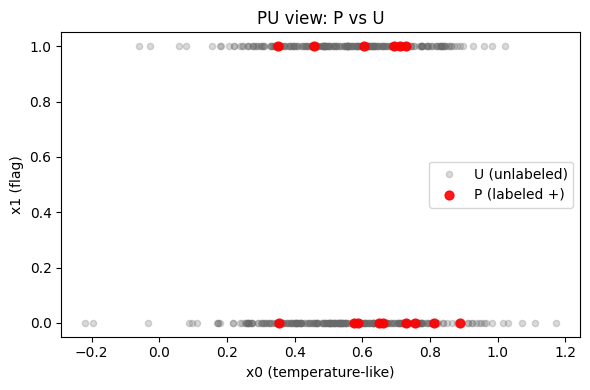

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(X_U[:, 0], X_U[:, 1], color='dimgray', alpha=0.25, s=20, label='U (unlabeled)')
plt.scatter(X_P[:, 0], X_P[:, 1], color='red', alpha=0.9, s=40, label='P (labeled +)')
plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (flag)')
plt.title('PU view: P vs U')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

Under SCAR, $ P(s=1\mid x)=c\,P(y=1\mid x) $. We first fit a classifier to predict **s** (P vs U). Then we estimate $ \hat c $ by averaging the s‑model’s probabilities on a **held‑out subset of P**. Finally, we divide by $ \hat c $ to get $ \hat P(y=1\mid x) $, clipping to `[0,1]`.

In [9]:
# Build s-dataset
X_s = np.vstack([X_P, X_U])
s_lab = np.hstack([np.ones(len(X_P), dtype=int), np.zeros(len(X_U), dtype=int)])

# Fit s-model
sc_s = StandardScaler().fit(X_s)
Xs_s = sc_s.transform(X_s)
clf_s = LogisticRegression(max_iter=300, random_state=0)
clf_s.fit(Xs_s, s_lab)

# Estimate c-hat on a holdout of P
XP_tr, XP_ho = train_test_split(X_P, test_size=0.15, random_state=0)
c_hat = clf_s.predict_proba(sc_s.transform(XP_ho))[:, 1].mean() if len(XP_ho) else 0.5
print("c_hat:", round(float(c_hat), 4))

# Convert to PU probability on all candidates (labeled pool + unlabeled pool)
X_all_plot = np.vstack([X_lab, X_unlab])
p_s_all = clf_s.predict_proba(sc_s.transform(X_all_plot))[:, 1]
p_y_all = np.clip(p_s_all / max(1e-6, c_hat), 0.0, 1.0)

# Split back for inspection
n_lab_total = X_lab.shape[0]
p_y_lab = p_y_all[:n_lab_total]
p_y_unl = p_y_all[n_lab_total:]
pd.Series(p_y_all).describe()

c_hat: 0.0384


count    570.000000
mean       0.652330
std        0.224119
min        0.153117
25%        0.468402
50%        0.632455
75%        0.841185
max        1.000000
dtype: float64

In [10]:
s_lab

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

```{admonition} Note
$ \hat c $ is the bridge from “probability of being revealed” to “probability of being truly positive.” Without it, the s‑model’s scores are systematically scaled.
```


At a fundamental level, we train model to predict “is this point from P or U?” and then rescale those scores to get a rough success probability. Keep the math light, the intuition strong.

Intuition
- If a spot in feature space is often seen among reported successes, it’s more likely to be truly positive.
- We estimate that likelihood with a classifier trained on P vs U.
- We then rescale with a constant `c` so that “reported” and “true” are aligned on average.

Below, we now visualize three views to build intuition.

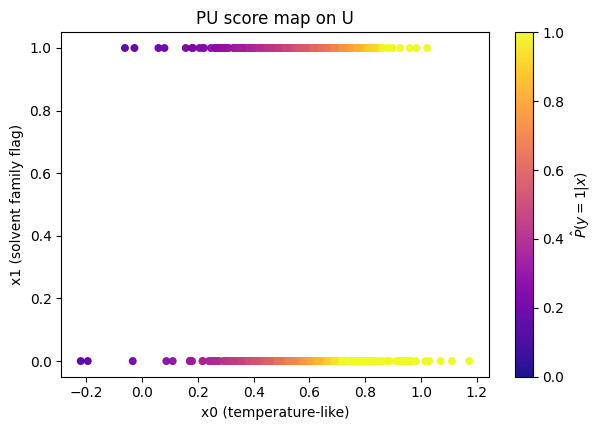

In [11]:
plt.figure(figsize=(6.2, 4.4))
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=p_y_unl, cmap='plasma', vmin=0, vmax=1, s=22, alpha=0.95)
plt.colorbar(label=r'$\hat P(y=1|x)$')
plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (solvent family flag)')
plt.title('PU score map on U')
plt.grid(False)
plt.tight_layout()
plt.show()

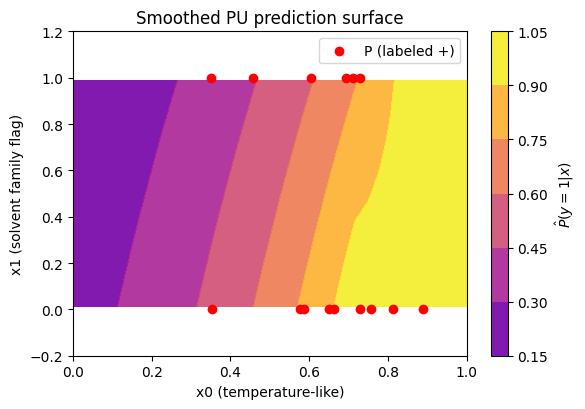

In [12]:
from scipy.interpolate import griddata
import numpy as np

# Create a fine grid
xg, yg = np.mgrid[0:1:100j, -0.2:1.2:100j]
zg = griddata(X_unlab, p_y_unl, (xg, yg), method='cubic')

plt.figure(figsize=(6.0, 4.2))
plt.contourf(xg, yg, zg, cmap='plasma', vmin=0, vmax=1, alpha=0.9)
plt.colorbar(label=r'$\hat P(y=1|x)$')
plt.scatter(X_P[:, 0], X_P[:, 1], color='red', s=36, label='P (labeled +)')
plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (solvent family flag)')
plt.title('Smoothed PU prediction surface')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

How do PU scores distribute for labeled positives vs labeled negatives (teach‑only), and how does U compare? Below we have a plot to see this:

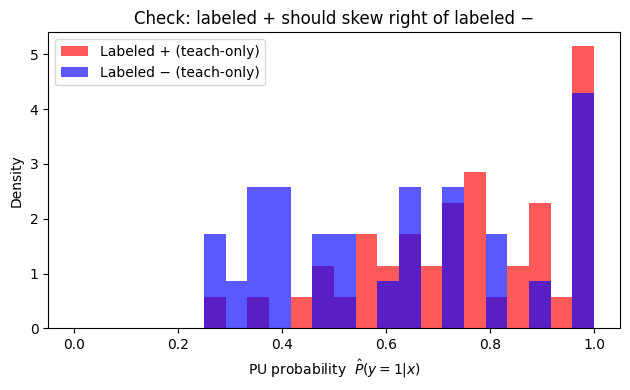

In [13]:
pos = (y_lab_noisy == 1)
neg = (y_lab_noisy == 0)
bins = np.linspace(0, 1, 25)

plt.figure(figsize=(6.4, 4))
plt.hist(p_y_lab[pos], bins=bins, density=True, alpha=0.65, color='red', label='Labeled + (teach-only)')
plt.hist(p_y_lab[neg], bins=bins, density=True, alpha=0.65, color='blue', label='Labeled − (teach-only)')
plt.xlabel('PU probability  $\\hat P(y=1|x)$')
plt.ylabel('Density')
plt.title('Check: labeled + should skew right of labeled −')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()



```{admonition} Note
To read it, you should expect labeled `+` often sits to the *right* of labeled `−`, meaning the model is ranking correctly (the postive labels should have higher PU probability). U should often look bimodal or broad.
```

Quantile threshold on U: 0.773


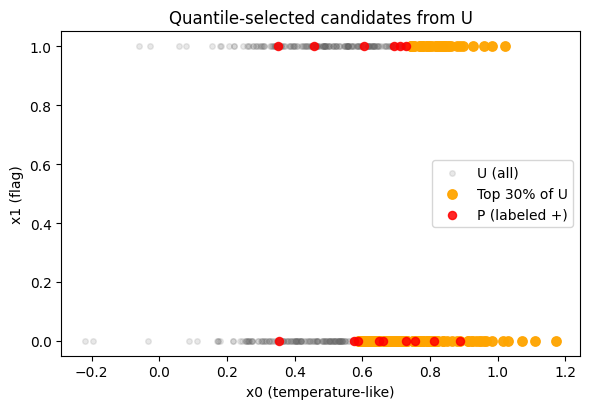

Selected 150 candidates by quantile threshold.


In [14]:
q = 0.30
thr_q = np.quantile(p_y_unl, 1 - q)
print("Quantile threshold on U:", round(float(thr_q), 3))

pick_q = np.where(p_y_unl >= thr_q)[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(6.0, 4.2))
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], color='dimgray', alpha=0.15, s=16, label='U (all)')
plt.scatter(X_unlab[pick_q, 0], X_unlab[pick_q, 1], color='orange', alpha=0.95, s=46, label=f'Top {int(q*100)}% of U')
plt.scatter(X_P[:, 0], X_P[:, 1], color='red', alpha=0.85, s=34, label='P (labeled +)')
plt.xlabel('x0 (temperature-like)')
plt.ylabel('x1 (flag)')
plt.title('Quantile-selected candidates from U')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Selected {pick_q.size} candidates by quantile threshold.")

Medthod 2: Prior‑guided threshold (volume driven):

In [15]:
pi_hat = float(p_y_all.mean())
print("Estimated class prior pi_hat:", round(pi_hat, 3))

thr_pi = np.quantile(p_y_unl, 1 - min(max(pi_hat, 0.01), 0.99))
print("Prior-guided threshold on U:", round(float(thr_pi), 3))

pick_pi = np.where(p_y_unl >= thr_pi)[0]
print(f"Selected {pick_pi.size} candidates by prior-guided threshold.")

Estimated class prior pi_hat: 0.652
Prior-guided threshold on U: 0.531
Selected 326 candidates by prior-guided threshold.


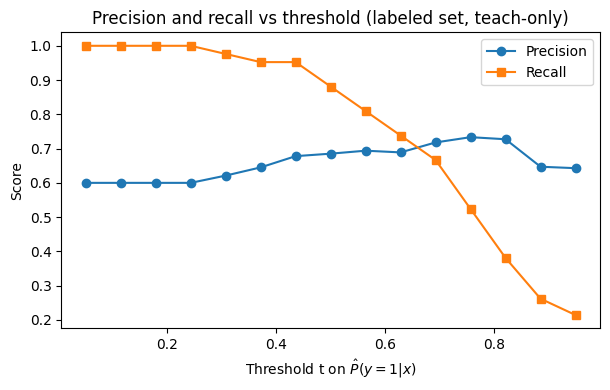

In [16]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

ths = np.linspace(0.05, 0.95, 15)
prec_list, rec_list = [], []
for t in ths:
    yhat = (p_y_lab >= t).astype(int)
    prec_list.append(precision_score(y_lab_noisy, yhat, zero_division=0))
    rec_list.append(recall_score(y_lab_noisy, yhat))

plt.figure(figsize=(6.2, 4.0))
plt.plot(ths, prec_list, marker='o', label='Precision')
plt.plot(ths, rec_list, marker='s', label='Recall')
plt.xlabel('Threshold t on $\\hat P(y=1|x)$')
plt.ylabel('Score')
plt.title('Precision and recall vs threshold (labeled set, teach-only)')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

---


## 4. MOF PU case study

Now use the provided MOF dataset and define positive as:

- yield $> 0.75$
- reproducibility $\ge 0.75$
- purity $> 0.50$

All other rows are considered failures, but in the **PU scenario** we will pretend we only observe a **small portion** of those true positives as labeled. Our goal is to recover $\hat P(y=1\mid x)$ for all candidates.

In [17]:
#Load MOF data
url = 'https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/mof_yield_dataset.csv'
df_raw = pd.read_csv(url)
df_raw.head(3)

,smiles,temperature,time_h,concentration_M,solvent_DMF,yield,purity,reproducibility
0,O=C(O)c1ccc(cc1)C(=O)O,25,12,0.05,0,0.29,0.55,1.0
1,O=C(O)/C=C/C(=O)O,25,12,0.05,0,0.42,0.45,1.0
2,Cc1ncc[nH]1,25,12,0.05,0,0.66,0.74,1.0


In [18]:
#Inspect basic columns and small sample
print(df_raw.columns.tolist())
df_raw.sample(5, random_state=1)

['smiles', 'temperature', 'time_h', 'concentration_M', 'solvent_DMF', 'yield', 'purity', 'reproducibility']


,smiles,temperature,time_h,concentration_M,solvent_DMF,yield,purity,reproducibility
11456,O=C(O)c1ccc2cccc(C(=O)O)c2c1,100,96,0.15,1,0.49,0.76,1.00
16528,O=C(O)c1ccc(cc1)-c2ccc(cc2)C(=O)O,155,36,0.35,0,0.35,0.26,0.75
3253,O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1,40,84,0.15,1,0.47,0.39,0.75
18614,Nc1cc(C(=O)O)ccc1C(=O)O,160,48,0.05,1,0.70,0.42,0.25
1544,Nc1cc(C(=O)O)ccc1C(=O)O,25,96,0.40,0,0.19,0.31,0.25


Define the positive condition and create the true label $y$ for teaching. In a real campaign you will not have $y$ for all rows.

In [19]:
# Define true positives (teaching) and simple features
df = df_raw.copy()
df['is_pos_true'] = ((df['yield'] > 0.75) & (df['reproducibility'] >= 0.75) & (df['purity'] > 0.50)).astype(int)
print('True positive rate:', df['is_pos_true'].mean().round(3))

# Use simple numeric process features + one-hot for solvent
X_num = df[['temperature','time_h','concentration_M','solvent_DMF']].astype(float).copy()
X = X_num.values
y_true = df['is_pos_true'].values
X[:2], y_true[:10]

True positive rate: 0.006


(array([[25.  , 12.  ,  0.05,  0.  ],
        [25.  , 12.  ,  0.05,  0.  ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Create the PU split: only a small fraction of the true positives are labeled as $s=1$.

In [20]:
# Create PU view: reveal only some positives as labeled s=1
rng = np.random.default_rng(123)
pi_p = y_true.mean()  # true class prior (teaching)
c_true = 0.3        # reveal rate among positives, we decide this number in demo but in reality you have no control on this
s = np.zeros_like(y_true, dtype=int)
pos_idx_all = np.where(y_true==1)[0]
reveal = rng.random(len(pos_idx_all)) < c_true
s[pos_idx_all[reveal]] = 1
print('Total rows:', len(y_true))
print('True positives:', int(y_true.sum()))
print('Labeled positives s=1:', int(s.sum()))

Total rows: 20000
True positives: 120
Labeled positives s=1: 40


Build the S-dataset for the MOF case: positives labeled vs unlabeled. Later we will fit a model for $s$.

In [21]:
# S-dataset for MOF
X_pos_labeled = X[s==1]
X_unl = X[s==0]
X_s = np.vstack([X_pos_labeled, X_unl])
s_lab = np.hstack([np.ones(len(X_pos_labeled)), np.zeros(len(X_unl))])
print('Shapes:', X_s.shape, s_lab.shape)
# Train s-model on MOF S-dataset
sc_s = StandardScaler().fit(X_s)
Xs_s = sc_s.transform(X_s)
clf_s = LogisticRegression(max_iter=400, random_state=5)
clf_s.fit(Xs_s, s_lab)
p_s_sdata = clf_s.predict_proba(Xs_s)[:,1]
pd.Series(p_s_sdata).describe()

Shapes: (20000, 4) (20000,)


count    20000.000000
mean         0.002000
std          0.001514
min          0.000257
25%          0.000819
50%          0.001513
75%          0.002804
max          0.008765
dtype: float64

Estimate $\hat c$ using a small holdout from the labeled positives.

In [22]:
#Estimate c-hat
Xp_tr, Xp_ho = train_test_split(X_pos_labeled, test_size=0.15, random_state=7)
p_s_pos_ho = clf_s.predict_proba(sc_s.transform(Xp_ho))[:,1]
c_hat = float(np.clip(p_s_pos_ho.mean(), 1e-6, 1.0))
print('c_hat (MOF):', round(c_hat,4))

c_hat (MOF): 0.0031


Compute $\hat P(y=1\mid x)$ for all rows and look at the distribution. This is your PU probability used for ranking and selection.

In [23]:
#PU probability for all MOF rows
p_s_all = clf_s.predict_proba(sc_s.transform(X))[:,1]
p_y_all = np.clip(p_s_all / c_hat, 0.0, 1.0)
pd.Series(p_y_all).describe()

count    20000.000000
mean         0.552614
std          0.315032
min          0.082458
25%          0.262625
50%          0.484961
75%          0.898812
max          1.000000
dtype: float64

Rank the top 10 candidates and print their conditions so that a chemist can sanity check them. This is often the most helpful first view.

In [24]:
# Top-10 by PU probability
top_idx = np.argsort(-p_y_all)[:10]
cols_show = ['temperature','time_h','concentration_M','solvent_DMF','yield','purity','reproducibility','is_pos_true']
df_top = df.iloc[top_idx][cols_show].copy()
df_top['p_y_hat'] = p_y_all[top_idx]
df_top.reset_index(drop=True)

,temperature,time_h,concentration_M,solvent_DMF,yield,purity,reproducibility,is_pos_true,p_y_hat
0,25,12,0.05,0,0.29,0.55,1.00,0,1.0
1,70,12,0.20,0,0.96,0.87,0.75,1,1.0
2,70,12,0.20,0,0.64,0.57,0.75,0,1.0
3,70,12,0.20,0,0.37,0.67,1.00,0,1.0
4,70,12,0.15,1,0.75,0.58,0.75,0,1.0
5,70,12,0.15,1,0.37,0.62,0.75,0,1.0
6,70,12,0.15,1,0.43,0.56,1.00,0,1.0
7,70,12,0.15,1,0.50,0.73,0.50,0,1.0
8,70,12,0.15,1,0.43,0.70,0.50,0,1.0
9,70,12,0.15,1,0.00,0.61,0.25,0,1.0


Teaching-only: if we use the hidden $y_{true}$ we can compute AUC and PR AUC as a robustness check for this lecture.

In [25]:
# Teaching-only metrics
auc_mof = roc_auc_score(y_true, p_y_all)
print('MOF PU AUC (teaching only):', round(auc_mof,3))


MOF PU AUC (teaching only):

 0.726


Plot PR curve and a simple cumulative hit rate curve for top-k. Both are useful in experiment planning.

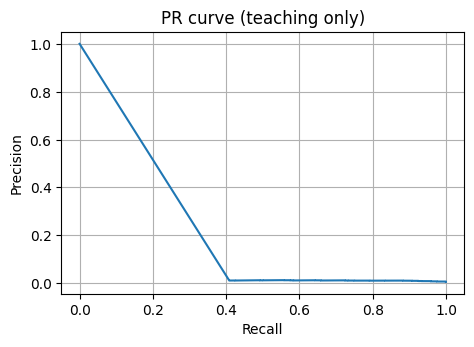

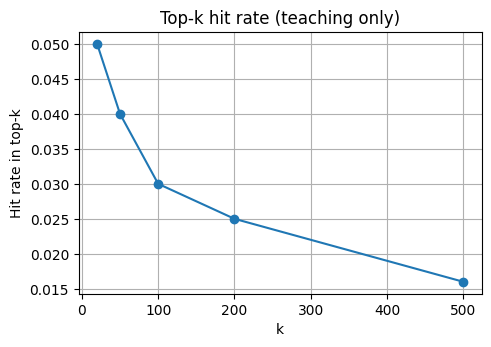

In [26]:
# Curves (teaching only)
prec, rec, thr = precision_recall_curve(y_true, p_y_all)
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR curve (teaching only)')
plt.show()

order = np.argsort(-p_y_all)
y_ordered = y_true[order]
topks = [20, 50, 100, 200, 500]
hits = []
for k in topks:
    k = min(k, len(y_ordered))
    hits.append(y_ordered[:k].mean())
plt.plot(topks, hits, marker='o')
plt.xlabel('k'); plt.ylabel('Hit rate in top-k'); plt.title('Top-k hit rate (teaching only)')
plt.show()

```{admonition} ⏰**Exercise**

Swap the base model to `RandomForestClassifier(n_estimators=500, min_samples_leaf=3)`. Re-estimate $\hat c$ and recompute `p_y_all`. Do the results change?
```

We can plot the probolities predicted by the model.
To run the code please use Colab, and below is the result.

In [27]:
from IPython.display import Image, display


display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lecture-17.umap1.png"))


```{admonition} Note
Now, chemist can start from the predictions done by semi-supervised learning to run the suggested experiments. 
```

In [28]:
from IPython.display import Image, display
display(Image(url="https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/lecture-17.umap2.png"))

## 5. Glossary

```{glossary}
SCAR
  Selected Completely At Random. Positives are labeled with a constant probability $c$, independent of $x$.

SAR
  Selected At Random. Label selection may depend on $x$. Harder than SCAR.

Class prior
  $\pi_p=P(y=1)$. Fraction of positives in the population. Important for risk correction.

Elkan–Noto link
  Under SCAR, $P(s=1\mid x)=c\,P(y=1\mid x)$. Estimate $c$ on a holdout of positives and divide.

PU probability
  An estimate of $P(y=1\mid x)$ produced from PU methods for ranking and decision.

```


---


## 6. In-class activity

### Q1. Identify PU pieces from LU toy data
Using the LU toy data you built (`X_lab`, `y_lab_noisy`, `X_unlab`), create a PU view by revealing only a fraction of the true positives as labeled. Report the shapes of P and U.

**Task**
1. From `y_lab_noisy`, take indices where `y=1`.
2. Reveal 30% at random as P.
3. Put the rest of `X_lab` plus all `X_unlab` into U.
4. Print shapes of P and U.

In [29]:
rng = np.random.default_rng(17)

pos_idx = np.where(y_lab_noisy == 1)[0]
reveal = rng.random(len(pos_idx)) < 0.30
P_idx = pos_idx[reveal]

X_P = X_lab[P_idx]
mask_lab_rest = np.ones(len(X_lab), dtype=bool)
mask_lab_rest[P_idx] = False
X_U = np.vstack([X_lab[mask_lab_rest], X_unlab])

print("P shape:", X_P.shape, " U shape:", X_U.shape)

P shape: (12, 2)  U shape: (558, 2)


---

### Q2. Train the s-model and estimate c-hat under SCAR
Train a classifier to predict selection `s` using P vs U. Then estimate `ĉ` by averaging `P(s=1|x)` on a held out split of P.

**Task**
1. Build `X_s`, `s_lab`.
2. Fit `LogisticRegression` or `RandomForestClassifier` (you decide).
3. Split P into train and holdout, compute `ĉ` as mean predicted probability on the holdout.

In [30]:
# Build s-dataset
X_s = np.vstack([X_P, X_U])
s_lab = np.hstack([np.ones(len(X_P), dtype=int), np.zeros(len(X_U), dtype=int)])

sc_s = StandardScaler().fit(X_s)
Xs_s = sc_s.transform(X_s)

s_clf = LogisticRegression(max_iter=400, random_state=17).fit(Xs_s, s_lab)

# Estimate c-hat on a P holdout
XP_tr, XP_ho = train_test_split(X_P, test_size=0.2, random_state=17)
c_hat = s_clf.predict_proba(sc_s.transform(XP_ho))[:, 1].mean() if len(XP_ho) else 0.5
print("c_hat:", round(float(c_hat), 4))

c_hat: 0.0333


---

### Q3. Convert s-scores to PU probabilities and rank candidates
Use the Elkan–Noto link under SCAR. Compute `P(y=1|x) ≈ P(s=1|x)/ĉ` and rank the top 10 U points.

**Task**
1. Score all U with the s-model.
2. Divide by `ĉ` and clip to `[0,1]`.
3. Show indices of the top 10 U points by PU probability.

In [31]:
p_s_u = s_clf.predict_proba(sc_s.transform(X_U))[:, 1]
p_y_u = np.clip(p_s_u / max(1e-6, c_hat), 0, 1)

top10 = np.argsort(-p_y_u)[:10]
pd.DataFrame({"u_index": top10, "p_y_hat": p_y_u[top10]}).reset_index(drop=True)

,u_index,p_y_hat
0,388,1.0
1,121,1.0
2,349,1.0
3,117,1.0
4,356,1.0
5,358,1.0
6,360,1.0
7,364,1.0
8,371,1.0
9,374,1.0


---

### Q4. Threshold selection by prior and by quantile
Pick candidates from U using two rules. Compare how many items each rule selects.

**Task**
1. Prior-guided threshold: estimate `π̂ = mean(p_y)` on the full candidate set `X_lab ∪ X_unlab` then pick top `π̂` fraction of U.
2. Fixed-quantile threshold: pick top 25% of U.
3. Report counts.

In [32]:
# Score everyone to estimate a coarse prior
X_all = np.vstack([X_lab, X_unlab])
p_s_all = s_clf.predict_proba(sc_s.transform(X_all))[:, 1]
p_y_all = np.clip(p_s_all / max(1e-6, c_hat), 0, 1)

pi_hat = float(p_y_all.mean())

# 1) Prior-guided threshold
thr_pi = np.quantile(p_y_u, 1 - min(max(pi_hat, 0.01), 0.99))
sel_pi = np.where(p_y_u >= thr_pi)[0]

# 2) Fixed-quantile 25%
thr_q = np.quantile(p_y_u, 0.75)
sel_q = np.where(p_y_u >= thr_q)[0]

print(f"pi_hat={pi_hat:.3f}  thr_pi={thr_pi:.3f}  selected_by_prior={len(sel_pi)}")
print(f"thr_q(25%)={thr_q:.3f}  selected_by_quantile={len(sel_q)}")

pi_hat=0.542  thr_pi=0.425  selected_by_prior=303
thr_q(25%)=0.815  selected_by_quantile=140
